In [ ]:
# 使用するモジュールをインポートします

import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
# 画像変換処理の定義をします
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))] )

# 学習データを読み込みます
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2)

# テストデータを読み込みます
testset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False,num_workers=2)

# クラス（認識する物体の種類）を定義します
classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

100%|██████████| 170M/170M [00:02<00:00, 79.1MB/s]


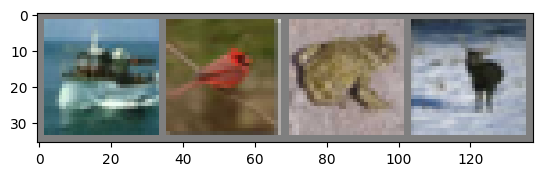

 ship  bird  frog  deer


In [ ]:
# 学習データの画像とラベルをランダムに表示するためのプログラム

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img=img/2+0.5
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

dataiter=iter(trainloader)
images,labels=next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [ ]:
# CNNを実装します

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  # 各層を定義
  def __init__(self):
    super(Net,self).__init__()
    # 畳み込み層１
    self.conv1=nn.Conv2d(3,6,5)
    # プーリング層
    self.pool=nn.MaxPool2d(2,2)
    # 畳み込み層２
    self.conv2=nn.Conv2d(6,16,5)
    # 全結合層
    self.fc1=nn.Linear(16*5*5,120)
    self.fc2=nn.Linear(120,84)
    self.fc3=nn.Linear(84,10)

  #  構成を定義
  def forward(self,x):
    # 畳み込み層１とプーリング層
    x=self.pool(F.relu(self.conv1(x)))
    # 畳み込み層２とプーリング層
    x=self.pool(F.relu(self.conv2(x)))
    # 全結合層用に並び替え
    x=x.view(-1,16*5*5)
    # 全結合層１
    x=F.relu(self.fc1(x))
    # 全結合層２
    x=F.relu(self.fc2(x))
    # 全結合層３から出力層
    x=self.fc3(x)
    return x

# CNNを生成
net=Net()



In [ ]:
# 損失関数とオプティマイザの定義

import torch.optim as optim

# 損失関数は交差エントロピー関数
criterion=nn.CrossEntropyLoss()
# 最適化はSGD
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [ ]:
# ２エポック学習

for epoch in range(2):
  running_loss=0.0

  # データセットの数だけ学習
  for i, data in enumerate(trainloader,0):
    inputs,labels=data
    optimizer.zero_grad()
    # 学習データの画像で推論
    outputs=net(inputs)
    # 損失関数で損失を求める
    loss=criterion(outputs,labels)
    # 逆伝搬で勾配を求める
    loss.backward()
    # パラメータ更新
    optimizer.step()
    # ２０００ミニバッチごとに損失の平均値を算出・出力
    running_loss+=loss.item()
    if i % 2000 == 1999:
      print('[%d,%5d]loss:%.3f'% (epoch+1,i+1,running_loss/2000))
      running_loss=0.0

print('Finished Training')


[1, 2000]loss:2.213
[1, 4000]loss:1.916
[1, 6000]loss:1.678
[1, 8000]loss:1.561
[1,10000]loss:1.508
[1,12000]loss:1.466
[2, 2000]loss:1.409
[2, 4000]loss:1.353
[2, 6000]loss:1.355
[2, 8000]loss:1.318
[2,10000]loss:1.322
[2,12000]loss:1.301
Finished Training


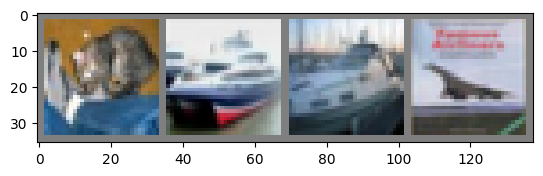

GroundTrush:   cat  ship  ship plane


In [ ]:
# テストデータ（先頭）用いてラベルと画像の一致を確認

dataiter=iter(testloader)
images, labels=next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTrush:',' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [ ]:
# 学習させたCNNでテストデータ（先頭）分類する

outputs=net(images)
_,predicted=torch.max(outputs,1)
print('Prediucted:',' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Prediucted:   cat  ship plane  ship


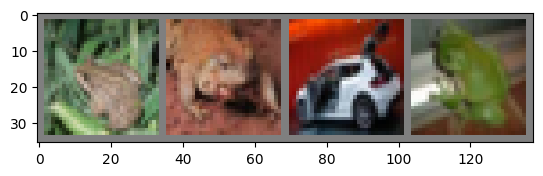

FriundTrust:  frog  frog   car  frog
predicted:  frog  frog  bird  frog


In [ ]:
# テストデータ（２つ目）を用いて、画像とラベルと分類結果を比較

images, labels=next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('FriundTrust:',' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs=net(images)
_, predicted=torch.max(outputs,1)
print('predicted:',' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [ ]:
# 全てのテストデータの正解率を求める

correct=0
total=0

with torch.no_grad():
  # 全てのテストデータを順に分類
  for data in testloader:
    images,labels=data
    outputs=net(images)
    _, predicted=torch.max(outputs.data,1)
    # テストデータと正解の数をカウント
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()

# 正解率を求めて出力
print('Accuracy of the network on 10000 test images:%d %%' % (100*correct/total))

Accuracy of the network on 10000 test images:53 %


In [ ]:
# クラス毎の正解率を出力

class_correct=list(0. for i in range(10))
class_total=list(0. for i in range(10))

with torch.no_grad():
  # 全てのテストデータを順に分類
  for data in testloader:
    images, labels=data
    outputs=net(images)
    _, predicted=torch.max(outputs,1)
    # クラス毎に正解の数をカウント
    c=(predicted==labels).squeeze()
    for i in range(4):
      label=labels[i]
      class_correct[label]+=c[i].item()
      class_total[label]+=1

# クラスごとの正解率を求めて出力
for i in range(10):
  print('Accuracy 0f %5s : %2d %%' % (classes[i],100*class_correct[i]/class_total[i]))

Accuracy 0f plane : 58 %
Accuracy 0f   car : 47 %
Accuracy 0f  bird : 38 %
Accuracy 0f   cat : 24 %
Accuracy 0f  deer : 36 %
Accuracy 0f   dog : 50 %
Accuracy 0f  frog : 65 %
Accuracy 0f horse : 75 %
Accuracy 0f  ship : 63 %
Accuracy 0f truck : 79 %
